## Importing Required Dependencies

In [214]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import os
import librosa
import librosa.display
import glob 
import skimage

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.preprocessing import StandardScaler
import joblib

import keras_tuner as kt 
import tensorflow as tf

## Dataset Preparation

###  Load and Prepare Data

In [215]:
df=pd.read_csv('./augmented_normal_data.csv')

X = df.drop(columns=['label']).values
y = df['label'].values

In [216]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (43660, 128)
Shape of y: (43660,)


### One-Hot Encoding

In [217]:
y=np.array(pd.get_dummies(y,dtype=int))

### SMOTE for Balanced Sampling

In [ ]:
# Assuming X and y are your features and target labels
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert one-hot encoded labels back to class labels
y_resampled_labels = np.argmax(y_resampled, axis=1)

# Check the distribution of data after resampling
counter = Counter(y_resampled_labels)
print("Class distribution after resampling:\n", counter)

### Data Split 

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=1, test_size=0.2)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (40000, 128)
Shape of X_test: (10000, 128)
Shape of y_train: (40000, 10)
Shape of y_test: (10000, 10)


### Scaling

In [220]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

joblib.dump(scaler, 'standard_scaler_cnn_2d.pkl')

['standard_scaler_cnn_2d.pkl']

In [221]:
X_train = X_train.reshape(len(X_train), 16, 8, 1)
X_test = X_test.reshape(len(X_test), 16, 8, 1)

In [222]:
input_dim = (16, 8, 1)

## Hyperparameter Tuning

### Function build_model

In [235]:
class CNNHyperModel(kt.HyperModel):
    
    def __init__(self, input_shape, output_units):
        self.input_shape = input_shape
        self.output_units = output_units

    def build(self, hp):
        model = Sequential()

        # First Conv2D layer
        model.add(Conv2D(
            filters=hp.Int('filters_1', min_value=32, max_value=256, step=32),
            kernel_size=(hp.Choice('kernel_height_1', values=[3, 5]), hp.Choice('kernel_width_1', values=[3, 5])),
            activation=hp.Choice('activation_1', values=['relu', 'tanh']),
            padding='same',
            input_shape=self.input_shape
        ))
        model.add(MaxPool2D(pool_size=(2, 2)))

        # Second Conv2D layer
        model.add(Conv2D(
            filters=hp.Int('filters_2', min_value=32, max_value=256, step=32),
           kernel_size=(hp.Choice('kernel_height_1', values=[3, 5]), hp.Choice('kernel_width_1', values=[3, 5])),
            activation=hp.Choice('activation_2', values=['relu', 'tanh']),
            padding='same'
        ))
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float('dropout_1', min_value=0, max_value=0.5, step=0.1)))

        # Flatten and Dense layers
        model.add(Flatten())
        model.add(Dense(hp.Int('dense_units', min_value=128, max_value=1024, step=128),
                        activation=hp.Choice('dense_activation', values=['relu', 'tanh'])))
        model.add(Dropout(hp.Float('dropout_2', min_value=0, max_value=0.5, step=0.1)))

        # Output layer
        model.add(Dense(self.output_units, activation='softmax'))

        # Compile the model
        model.compile(
            optimizer=tf.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

In [236]:
input_shape = (input_dim)  # Replace input_dim with the actual input shape
output_units = y_train.shape[1]  # Define the number of classes for the output layer

# Initialize CNNHyperModel
cnn_hypermodel = CNNHyperModel(input_shape=input_shape, output_units=output_units)

# Set up early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Set up Keras Tuner with RandomSearch strategy
possible_epochs = [50, 100]

for epoch_count in possible_epochs:
    print(f"Training with {epoch_count} epochs")

    tuner = kt.RandomSearch(
        cnn_hypermodel,
        objective='val_accuracy',
        max_trials=10,  # Number of different hyperparameter combinations to try
        executions_per_trial=1,  # Number of executions for each trial
        directory='cnn_tuner',
        project_name=f'cnn_epoch_{epoch_count}'
    )

    # Start the hyperparameter search
    tuner.search(
        X_train, y_train,
        epochs=epoch_count,
        validation_split=0.2,
        callbacks=[early_stopping]
    )

    # Retrieve the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best hyperparameters for {epoch_count} epochs: {best_hps.values}")

Training with 50 epochs
Reloading Tuner from cnn_tuner/cnn_epoch_50/tuner0.json
Best hyperparameters for 50 epochs: {'filters_1': 192, 'kernel_height_1': 3, 'kernel_width_1': 3, 'activation_1': 'tanh', 'filters_2': 160, 'activation_2': 'relu', 'dropout_1': 0.4, 'dense_units': 512, 'dense_activation': 'relu', 'dropout_2': 0.30000000000000004, 'learning_rate': 0.0014017048798120248, 'tuner/epochs': 6, 'tuner/initial_epoch': 2, 'tuner/bracket': 3, 'tuner/round': 1, 'tuner/trial_id': '0003'}
Training with 100 epochs
Reloading Tuner from cnn_tuner/cnn_epoch_100/tuner0.json
Best hyperparameters for 100 epochs: {'filters_1': 224, 'kernel_height_1': 3, 'kernel_width_1': 3, 'activation_1': 'relu', 'filters_2': 64, 'activation_2': 'tanh', 'dropout_1': 0.1, 'dense_units': 1024, 'dense_activation': 'relu', 'dropout_2': 0.2, 'learning_rate': 0.00031255246099284477}


### Best hyperparameters

In [248]:
# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
for hp_name, hp_value in best_hyperparameters.values.items():
    print(f"{hp_name}: {hp_value}")

Best Hyperparameters:
filters_1: 224
kernel_height_1: 3
kernel_width_1: 3
activation_1: relu
filters_2: 64
activation_2: tanh
dropout_1: 0.1
dense_units: 1024
dense_activation: relu
dropout_2: 0.2
learning_rate: 0.00031255246099284477


In [249]:
import pandas as pd

# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Convert hyperparameters to a pandas DataFrame
hyperparameters_df = pd.DataFrame(list(best_hyperparameters.values.items()), columns=["Hyperparameter", "Value"])

In [250]:
hyperparameters_df

,Hyperparameter,Value
0,filters_1,224
1,kernel_height_1,3
2,kernel_width_1,3
3,activation_1,relu
4,filters_2,64
5,activation_2,tanh
6,dropout_1,0.1
7,dense_units,1024
8,dense_activation,relu
9,dropout_2,0.2


### Best hyperparameters for diffrenet epochs

In [241]:
import pandas as pd

# Initialize a list to hold dictionaries of hyperparameters for each epoch count
hyperparameters_list = []

for epoch_count in possible_epochs:
    # Retrieve the stored Keras Tuner object for each epoch
    tuner = kt.RandomSearch(
        cnn_hypermodel,
        objective='val_accuracy',
        max_trials=10,  # Number of different hyperparameter combinations to try
        executions_per_trial=1,  # Number of executions for each trial
        directory='cnn_tuner',
        project_name=f'cnn_epoch_{epoch_count}'
    )

    # Get best hyperparameters
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0].values

    # Add the epoch count to the dictionary of hyperparameters
    hyperparameters = {"epoch_count": epoch_count, **best_hyperparameters}

    # Append the dictionary to the list
    hyperparameters_list.append(hyperparameters)

# Create a DataFrame from the list of hyperparameter dictionaries
best_params_df = pd.DataFrame(hyperparameters_list)

# Specify columns to keep
columns_to_keep = [
    'epoch_count', 'filters_1', 'kernel_height_1', 'kernel_width_1', 
    'activation_1', 'filters_2', 'activation_2', 'dropout_1', 
    'dense_units', 'dense_activation', 'dropout_2'
]

# Filter DataFrame to display only the desired columns
best_params_df_filtered = best_params_df[columns_to_keep]


Reloading Tuner from cnn_tuner/cnn_epoch_50/tuner0.json
Reloading Tuner from cnn_tuner/cnn_epoch_100/tuner0.json


In [243]:
best_params_df_filtered

,epoch_count,filters_1,kernel_height_1,kernel_width_1,activation_1,filters_2,activation_2,dropout_1,dense_units,dense_activation,dropout_2
0,50,192,3,3,tanh,160,relu,0.4,512,relu,0.3
1,100,224,3,3,relu,64,tanh,0.1,1024,relu,0.2


### Best Model Test

In [226]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

In [227]:
best_model.save('best_cnn_2d_model.keras')

In [228]:
test_accuracy=best_model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.9524000287055969


In [229]:
# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
for hp_name, hp_value in best_hyperparameters.values.items():
    print(f"{hp_name}: {hp_value}")

Best Hyperparameters:
filters_1: 224
kernel_height_1: 3
kernel_width_1: 3
activation_1: relu
filters_2: 64
activation_2: tanh
dropout_1: 0.1
dense_units: 1024
dense_activation: relu
dropout_2: 0.2
learning_rate: 0.00031255246099284477


## Train the Best Model again

Epoch 1/100
1000/1000 [==============================] - 12s 11ms/step - loss: 1.4846 - accuracy: 0.4839 - val_loss: 1.2665 - val_accuracy: 0.5562
Epoch 2/100
1000/1000 [==============================] - 11s 11ms/step - loss: 1.1224 - accuracy: 0.6077 - val_loss: 1.0271 - val_accuracy: 0.6421
Epoch 3/100
1000/1000 [==============================] - 11s 11ms/step - loss: 0.9646 - accuracy: 0.6654 - val_loss: 0.9021 - val_accuracy: 0.6917
Epoch 4/100
1000/1000 [==============================] - 11s 11ms/step - loss: 0.8512 - accuracy: 0.7027 - val_loss: 0.8041 - val_accuracy: 0.7253
Epoch 5/100
1000/1000 [==============================] - 11s 11ms/step - loss: 0.7696 - accuracy: 0.7340 - val_loss: 0.7535 - val_accuracy: 0.7441
Epoch 6/100
1000/1000 [==============================] - 11s 11ms/step - loss: 0.7033 - accuracy: 0.7601 - val_loss: 0.6699 - val_accuracy: 0.7717
Epoch 7/100
1000/1000 [==============================] - 11s 11ms/step - loss: 0.6513 - accuracy: 0.7763 - val_loss: 0

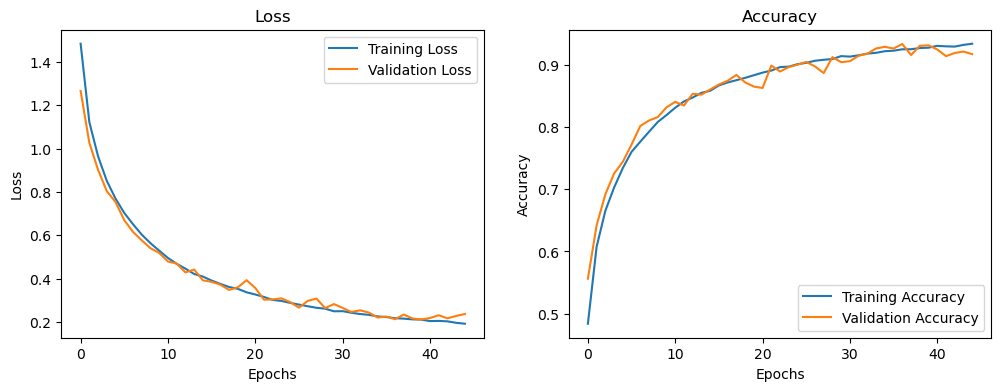

In [244]:
# Rebuild the best model using the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Initialize the hypermodel with input and output parameters
cnn_hypermodel = CNNHyperModel(input_shape=input_shape, output_units=output_units)

# Build the model using the best hyperparameters
model = cnn_hypermodel.build(best_hyperparameters)

# Train the model again, this time keeping track of the history for plotting
history = model.fit(
    X_train, y_train,
    epochs=100,  # You can set an appropriate number of epochs here
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Plotting Training and Validation Loss and Accuracy
plt.figure(figsize=(12, 4))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [245]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.9373999834060669


In [255]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 16, 8, 224)        2240      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 4, 224)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 4, 64)          129088    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 2, 64)          0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 4, 2, 64)          0         
                                                                 
 flatten_2 (Flatten)         (None, 512)              

## Classfication Report 

In [267]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Example of class names
class_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

# Generate predictions for the test set
y_pred = (model.predict(X_test) > 0.).astype("int32")

# Get the class labels from the one-hot encoded predictions and true values
y_pred_classes = np.argmax(y_pred, axis=-1)
y_test_classes = np.argmax(y_test, axis=-1)

# Print the classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

313/313 [==============================] - 1s 3ms/step
                  precision    recall  f1-score   support

 air_conditioner       0.70      0.97      0.81      1016
        car_horn       1.00      0.96      0.98      1010
children_playing       0.84      0.83      0.84       939
        dog_bark       0.98      0.85      0.91       987
        drilling       0.97      0.97      0.97      1000
   engine_idling       0.97      0.95      0.96       993
        gun_shot       1.00      0.97      0.98       986
      jackhammer       0.99      0.99      0.99      1072
           siren       0.95      0.91      0.93      1032
    street_music       0.98      0.85      0.91       965

        accuracy                           0.93     10000
       macro avg       0.94      0.92      0.93     10000
    weighted avg       0.94      0.93      0.93     10000



## Confution Matrix

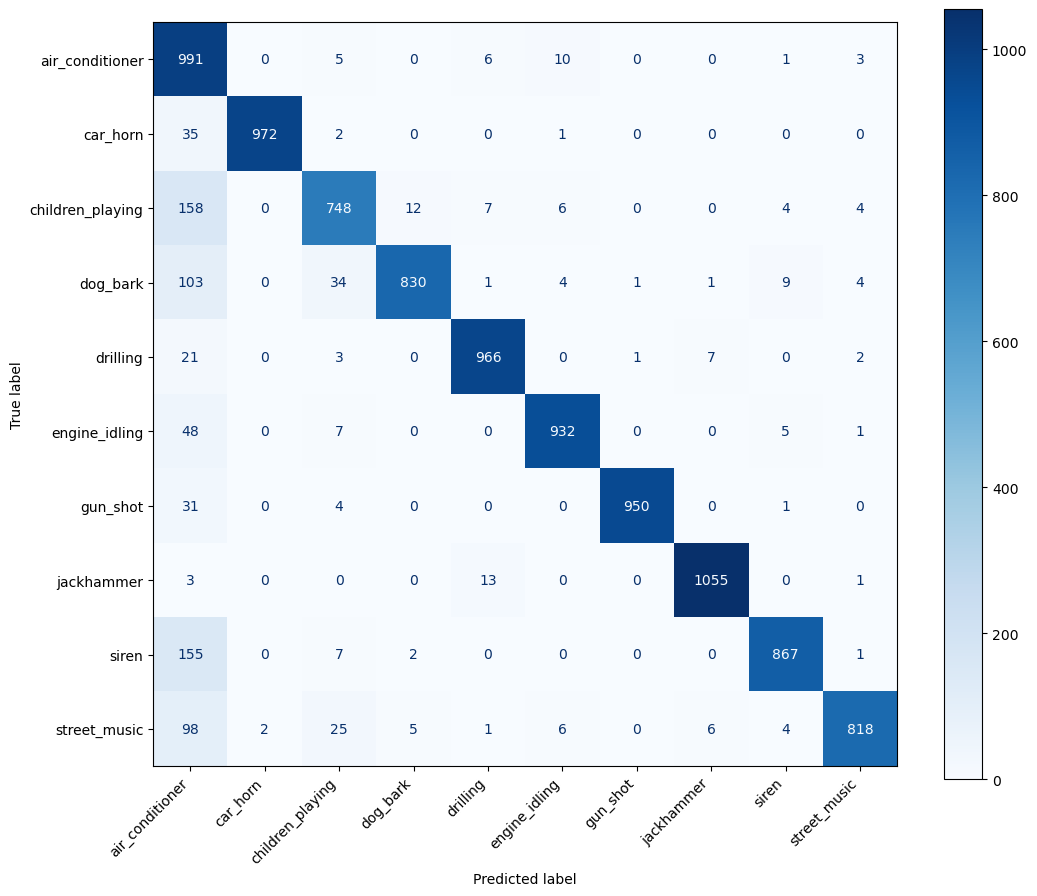

In [259]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))  # Specify figure size directly in subplots

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

disp.plot(cmap=plt.cm.Blues, ax=ax)  # Pass the axis to the plot method

ax.set_xticklabels(disp.display_labels, rotation=45, ha='right')  # Rotate class names on x-axis for better readability

plt.show()